# DOC-VQA SER实战

本节将介绍如何使用PaddleOCR完成DOC-VQA SER算法的训练与运行，包括：

1. 理解DOC-VQA SER算法原理
2. 掌握PaddleOCR里DOC-VQA SER代码的训练流程

## 1. 快速体验

准备代码和环境

In [ ]:
# clone PaddleOCR代码
# ! git clone https://github.com/PaddlePaddle/PaddleOCR

# 安装依赖包
! pip install -U pip
! pip install -r /home/aistudio/PaddleOCR/requirements.txt
! pip install paddleocr

# 安装依赖包
! pip install yacs gnureadline paddlenlp==2.2.1

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:
# 切换到 vqa 目录
import os
os.chdir('/home/aistudio/PaddleOCR/ppstructure/vqa')

In [ ]:
# 下载模型
! mkdir inference
# 下载SER模型的检测模型并解压
! wget -P ./inference/ https://paddleocr.bj.bcebos.com/pplayout/PP-Layout_v1.0_ser_pretrained.tar && cd inference && tar xf PP-Layout_v1.0_ser_pretrained.tar && cd ..

--2021-12-22 16:03:11--  https://paddleocr.bj.bcebos.com/pplayout/PP-Layout_v1.0_ser_pretrained.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.195, 182.61.200.229, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1481431040 (1.4G) [application/x-tar]
Saving to: ‘./inference/PP-Layout_v1.0_ser_pretrained.tar’

PP-Layout_v1.0_ser_ 100%[===================>]   1.38G  45.5MB/s    in 31s     

2021-12-22 16:03:42 (45.6 MB/s) - ‘./inference/PP-Layout_v1.0_ser_pretrained.tar’ saved [1481431040/1481431040]



W1226 20:10:47.258977   900 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W1226 20:10:47.263010   900 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[2021/12/26 20:10:57] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.

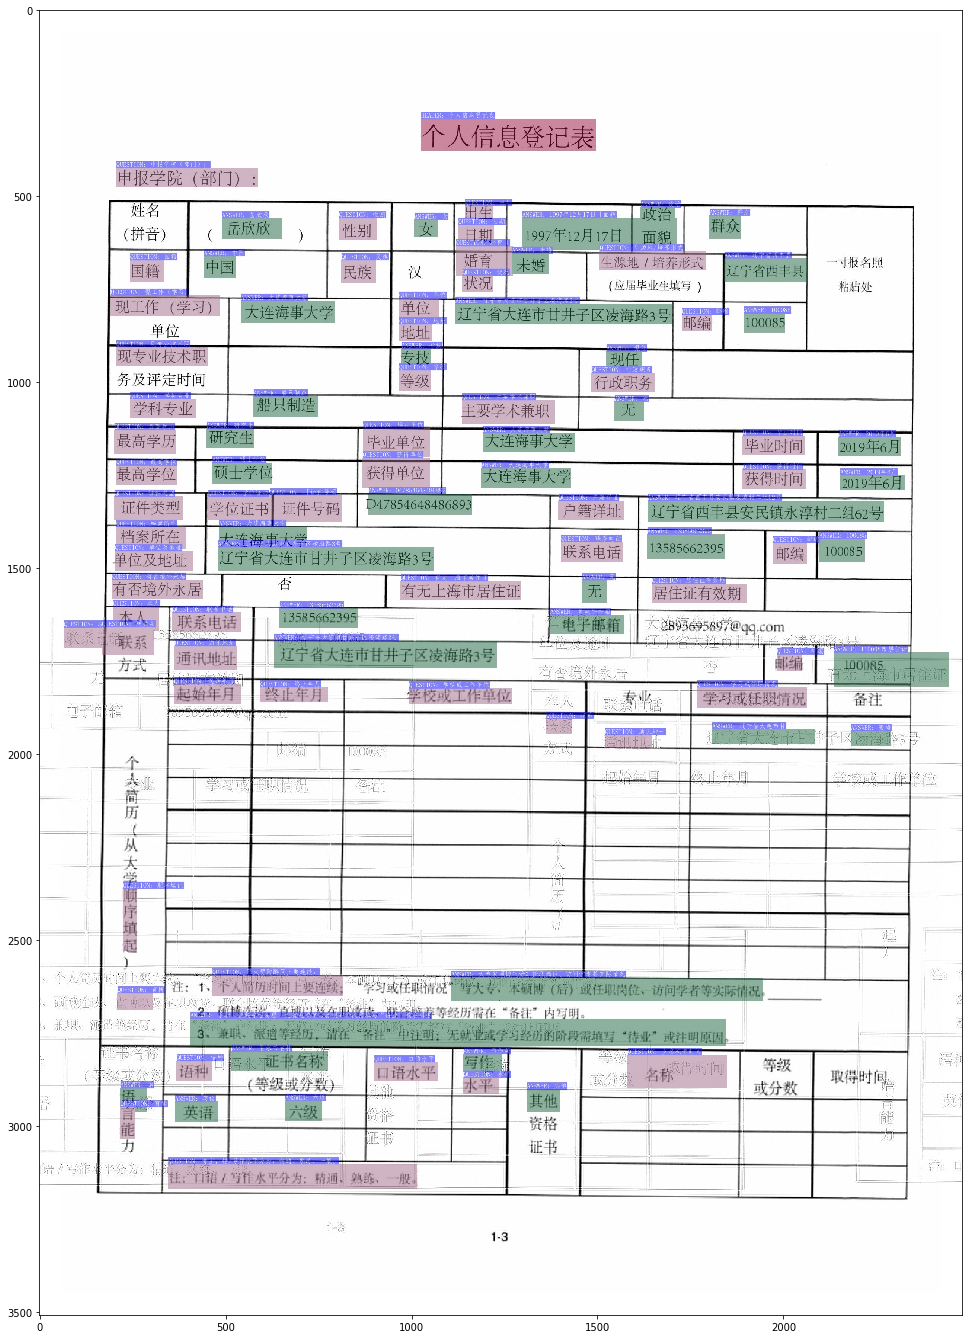

In [ ]:
# 执行 SER 预测
# https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/ppstructure/vqa/infer_ser_e2e.py

! python infer_ser_e2e.py \
    --model_name_or_path "./inference/PP-Layout_v1.0_ser_pretrained/" \
    --max_seq_length 512 \
    --output_dir "output/res_e2e/" \
    --infer_imgs "images/input/zh_val_42.jpg"
    
import cv2
from matplotlib import pyplot as plt
# 在notebook中使用matplotlib.pyplot绘图时，需要添加该命令进行显示
%matplotlib inline

img = cv2.imread('output/res_e2e/zh_val_42_ser.jpg')
plt.figure(figsize=(48,24))
plt.imshow(img)

## 2. 原理详解

PaddleOCR中DOC-VQA系列算法目前基于[LayoutXLM](https://arxiv.org/pdf/2104.08836.pdf)论文实现，提供了SER和RE两种任务

LayoutXLM是LayoutLMV2的多语言版本，LayoutLMV2原理图如下：

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/82762e847487489ea92ead44679bbfbed5e5d0acbcf94a3081524ce50d29f513" width="1000" ></center>
<br><center>图1 LayoutLMV2算法</center>

相对于NLP中的Bert，LayoutXLM在模型的输入端新增了Image和图像内文字的Layout信息，LayoutXLM已经在PaddleNLP中实现，因此这里从模型前向的角度介绍数据和网络。

### 2.1 输入数据处理

首先对图像进行ocr识别或pdf解析，获取text及bbox信息，在此基础上构建模型的三个输入：

1. Text Embedding

	首先对OCR识别的文本使用 WordPiece 进行切分，之后添加 [CLS] 和 [SEP] 标记，并用 [PAD] 补齐长度得到文本输入序列如下：
  
   $$S=\{[CLS], w_1, w_2, \cdots , [SEP], [PAD], [PAD], \cdots \}, |S|=L$$
	
    再将词向量、一维位置向量、分段向量相加得到文本向量，公式如下：
    
   $$t_i=TokEmb(w_i)+PosEmb1D(i)+SegEmb(s_i), 0 \leq i<L$$ 
    
    一维位置向量：词的索引
    
    分段向量：A

In [ ]:
# Text Embedding 演示

from paddlenlp.transformers import LayoutXLMTokenizer

tokenizer = LayoutXLMTokenizer.from_pretrained('inference/PP-Layout_v1.0_ser_pretrained')
# 分词
print('分词结果：', tokenizer.tokenize('我的中国心'))
# 转换为索引
print('转换为索引结果：', tokenizer.encode('我的中国心'))

分词结果： ['▁我', '的中国', '心']
转换为索引结果： {'input_ids': [0, 13129, 84072, 1801, 2], 'token_type_ids': [0, 0, 0, 0, 0]}


2. Image Embedding

	我们使用 ResNeXt-FPN 网络作为图像编码器，首先抽取原始文档图像的特征图，再将其平均池化为固定尺寸（B * 256 * 7 * 7），接着按行展开平均池化后的特征图（B * 256 * 49），之后经过线性投影（B * 49 * 256），就可以得到图像对应的特征序列。和文本向量的组成对应，图像向量也补充了一维相对位置和分段信息。最后将特征向量、一维位置向量、分段向量相加就可以得到最终的图像向量，如下所示：
    
 	$$v_i=Proj(VisTokEmb(I)_i)+PosEmb1D(i)+SegEmb([C]), 0 \leq i<WH$$
    
    分段向量：C
3. Layout Embedding

	对应于每个词或图像区域在页面中覆盖的坐标范围，使用平行于坐标轴的边界框（bounding box）表示布局信息，每个边界框用4个边界坐标值、宽、高来表示。最终的布局向量由6个特征对应的向量拼接得到：
    
   $$I_i=Concat(PosEmb2D_x(x_0, x_1, w), PosEmb2D_y(y_0, y_1, h)), 0 \leq i<WH+L$$
   

下面演示预测过程中，从输入一张图像构建网络输入的过程，整个过程主要包含下面几个步骤

1. 对图像进行OCR识别
2. 对图像进行预处理，包括缩放到指定大小和归一化
3. 对识别到的文本进行分词和转index
4. 对文本框进行归一化，使其值在0-1000之间
5. 对3，4处理后的结果进行pad，便于组batch

In [ ]:
# 预测输入构建
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppstructure/vqa/vqa_utils.py

import cv2
import numpy as np
import paddle
from copy import deepcopy
from paddleocr import PaddleOCR
from paddlenlp.transformers import LayoutXLMTokenizer

from infer_ser_e2e import trans_poly_to_bbox,pad_sentences,split_page

def parse_ocr_info_for_ser(ocr_result):
    # ocr结果转字典形式，文本框转换为外接矩形
    ocr_info = []
    for res in ocr_result:
        ocr_info.append({
            "text": res[1][0],
            "bbox": trans_poly_to_bbox(res[0]),
            "poly": res[0],
        })
    return ocr_info

def preprocess(
        tokenizer,
        ori_img,
        ocr_info,
        img_size=(224, 224),
        pad_token_label_id=-100,
        max_seq_len=512,
        add_special_ids=False,
        return_attention_mask=True, ):
    ocr_info = deepcopy(ocr_info)
    height = ori_img.shape[0]
    width = ori_img.shape[1]
    
    # 图像resize到指定shape
    img = cv2.resize(ori_img, img_size).transpose([2, 0, 1]).astype(np.float32)
    
    segment_offset_id = [] # 存储了每个文本在input_ids里的结束位置
    bbox_list = [] # 存储归一化到 0-1000 的box
    input_ids_list = [] # 存储文本经过分词之后的文本段在词表里的索引
    token_type_ids_list = [] # 存储文本段的类别信息

    for info in ocr_info:
        # box 归一化到 0-1000
        # x1, y1, x2, y2
        bbox = info["bbox"]
        bbox[0] = int(bbox[0] * 1000.0 / width)
        bbox[2] = int(bbox[2] * 1000.0 / width)
        bbox[1] = int(bbox[1] * 1000.0 / height)
        bbox[3] = int(bbox[3] * 1000.0 / height)
        
        # 对 文本信息进行 tokenizer, 包含分词和转换为词表里的 index
        text = info["text"]
        encode_res = tokenizer.encode(
            text, pad_to_max_seq_len=False, return_attention_mask=True)
        
        # 根据参数决定是否删掉特殊的字符
        if not add_special_ids:
            # TODO: use tok.all_special_ids to remove
            encode_res["input_ids"] = encode_res["input_ids"][1:-1]
            encode_res["token_type_ids"] = encode_res["token_type_ids"][1:-1]
            encode_res["attention_mask"] = encode_res["attention_mask"][1:-1]

        input_ids_list.extend(encode_res["input_ids"])
        token_type_ids_list.extend(encode_res["token_type_ids"])
        bbox_list.extend([bbox] * len(encode_res["input_ids"]))
        segment_offset_id.append(len(input_ids_list))

    encoded_inputs = {
        "input_ids": input_ids_list,
        "token_type_ids": token_type_ids_list,
        "bbox": bbox_list,
        "attention_mask": [1] * len(input_ids_list),
    }
    # 将 val pad到指定长度，不足长度的用 0 进行补充
    encoded_inputs = pad_sentences(
        tokenizer,
        encoded_inputs,
        max_seq_len=max_seq_len,
        return_attention_mask=return_attention_mask)
    
    # input_ids> 512 时，划分为2个batch
    ncoded_inputs = split_page(encoded_inputs)

    fake_bs = encoded_inputs["input_ids"].shape[0]

    encoded_inputs["image"] = paddle.to_tensor(img).unsqueeze(0).expand(
        [fake_bs] + list(img.shape))

    encoded_inputs["segment_offset_id"] = segment_offset_id

    return encoded_inputs

img = cv2.imread('images/input/zh_val_42.jpg')

ocr_engine = PaddleOCR(use_angle_cls=False,show_log=False)
# 执行ocr识别
ocr_result = ocr_engine.ocr(img, cls=False)
# ocr结果转字典形式，文本框转换为外接矩形
ocr_info = parse_ocr_info_for_ser(ocr_result)


tokenizer = LayoutXLMTokenizer.from_pretrained('inference/PP-Layout_v1.0_ser_pretrained')
# 对图像进行resize，
# 对文本进行分词，转换为词典索引等操作，
# 对box进行归一化
max_seq_length = 512
inputs = preprocess(tokenizer=tokenizer,ori_img=img,ocr_info=ocr_info,max_seq_len=max_seq_length, img_size=(224,224))

print(inputs.keys())
print(inputs['image'].shape)

[2021/12/26 20:11:19] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pg

Corrupt JPEG data: premature end of data segment


dict_keys(['input_ids', 'token_type_ids', 'bbox', 'attention_mask', 'image', 'segment_offset_id'])
[2, 3, 224, 224]


经过处理后的数据为一个字典，包含下面几个字段:
<center>
  
| 字段 | 含义 |
|---|---|
|image| resize为224*224的图像 |
|bbox| 归一化到 0-1000 的box |
|input_ids| 文本经过分词之后的文本段在词表里的索引 |
|token_type_ids| 文本段的类别信息|
|attention_mask| 对文本段进行mask的掩码，特殊字符对应位置标记为0，文本段对应位置标记为1 |
|segment_offset_id| 记录了每个文本在input_ids里的结束位置|
  
<center/>

### 2.2 SER网络

SER: 语义实体识别 (Semantic Entity Recognition）, 可以完成对图像中的文本识别与分类。 
SER网络LayoutXLMModel的输出上加了一个全连接的分类头，其网络代码如下：

In [ ]:
# https://github.com/PaddlePaddle/PaddleNLP/blob/develop/paddlenlp/transformers/layoutxlm/modeling.py#L846

from paddlenlp.transformers import LayoutXLMPretrainedModel
from paddle import nn
class LayoutXLMForTokenClassification(LayoutXLMPretrainedModel):
    def __init__(self, layoutxlm, num_classes=2, dropout=None):
        super(LayoutXLMForTokenClassification, self).__init__()
        self.num_classes = num_classes
        if isinstance(layoutxlm, dict):
            self.layoutxlm = LayoutXLMModel(**layoutxlm)
        else:
            self.layoutxlm = layoutxlm
        self.dropout = nn.Dropout(dropout if dropout is not None else self.layoutxlm.config["hidden_dropout_prob"])
        self.classifier = nn.Linear(self.layoutxlm.config["hidden_size"],num_classes)
        self.classifier.apply(self.init_weights)

    def get_input_embeddings(self):
        return self.layoutxlm.embeddings.word_embeddings

    def forward(self, input_ids=None, bbox=None, image=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, labels=None):
        # backbone 运算
        outputs = self.layoutxlm(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask)
        seq_length = input_ids.shape[1]
        # head 运算
        sequence_output, image_output = outputs[0][:, :seq_length], outputs[0][:, seq_length:]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        outputs = logits,
        
        # 计算loss
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()

            if attention_mask is not None:
                active_loss = attention_mask.reshape([-1, ]) == 1
                active_logits = logits.reshape([-1, self.num_classes])[active_loss]
                active_labels = labels.reshape([-1, ])[active_loss]
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.reshape([-1, self.num_classes]),labels.reshape([-1, ]))
            outputs = (loss, ) + outputs
        return outputs

In [ ]:
# 初始化网络
net = LayoutXLMForTokenClassification.from_pretrained('inference/PP-Layout_v1.0_ser_pretrained')
net.eval()
# 执行网络前向
outputs = net(input_ids=inputs["input_ids"],
            bbox=inputs["bbox"],
            image=inputs["image"],
            token_type_ids=inputs["token_type_ids"],
            attention_mask=inputs["attention_mask"])
print(outputs[0].shape)

[2, 512, 7]


### 2.3 后处理

后处理主要完成将模型输出的文本锻的预测结果对应到文本上，并且将结果和ocr的结果进行结合，主要包含以下几个步骤

1. 每一个文本，统计该文本下所有文本段预测的label
2. 选取所有文本段预测最多的label作为该文本的label

In [ ]:
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppstructure/vqa/vqa_utils.py

import paddle
import numpy as np

from infer_ser_e2e import get_bio_label_maps

label2id_map, id2label_map = get_bio_label_maps('labels/labels_ser.txt')

def postprocess(attention_mask, preds, id2label_map):
    if isinstance(preds, paddle.Tensor):
        preds = preds.numpy()
    preds = np.argmax(preds, axis=2)

    preds_list = [[] for _ in range(preds.shape[0])]

    # keep batch info
    for i in range(preds.shape[0]):
        for j in range(preds.shape[1]):
            if attention_mask[i][j] == 1:
                preds_list[i].append(id2label_map[preds[i][j]])

    return preds_list

def merge_preds_list_with_ocr_info(ocr_info, segment_offset_id, preds_list,
                                   label2id_map_for_draw):
    # list flatten
    preds = [p for pred in preds_list for p in pred]
    
    # label2idx的字典转换为idx2label的字段，去掉B-和I-的前缀
    id2label_map = dict()
    for key in label2id_map_for_draw:
        val = label2id_map_for_draw[key]
        if key == "O":
            id2label_map[val] = key
        if key.startswith("B-") or key.startswith("I-"):
            id2label_map[val] = key[2:]
        else:
            id2label_map[val] = key
    print("id2label_map:",id2label_map)
    
    # 对每一个文本，统计预测的label
    for idx in range(len(segment_offset_id)):
        if idx == 0:
            start_id = 0
        else:
            start_id = segment_offset_id[idx - 1]
    
        end_id = segment_offset_id[idx]
        # 拿出文本在 输出里的范围
        curr_pred = preds[start_id:end_id]
        # 拿出文本在 输出里的所有预测结果
        curr_pred = [label2id_map_for_draw[p] for p in curr_pred]

        if len(curr_pred) <= 0:
            pred_id = 0
        else:
            # print("pred label:",curr_pred)
            # 对label进行计数
            counts = np.bincount(curr_pred)
            # print("counts:",counts)
            pred_id = np.argmax(counts)
        ocr_info[idx]["pred_id"] = int(pred_id)
        ocr_info[idx]["pred"] = id2label_map[int(pred_id)]
        # print("pred label:",id2label_map[int(pred_id)])
    return ocr_info

preds = postprocess(inputs["attention_mask"], outputs[0], id2label_map)

# I 开头的value label替换为 B开头的
label2id_map_for_draw = dict()
for key in label2id_map:
    if key.startswith("I-"):
        label2id_map_for_draw[key] = label2id_map["B" + key[1:]]
    else:
        label2id_map_for_draw[key] = label2id_map[key]
print("label2id_map:",label2id_map)
print("label2id_map_for_draw:",label2id_map_for_draw)
# 将预测信息和ocr信息合并
ocr_info_with_ser = merge_preds_list_with_ocr_info(ocr_info, inputs["segment_offset_id"], preds, label2id_map_for_draw)
print(ocr_info_with_ser)

label2id_map: {'O': 0, 'B-QUESTION': 1, 'I-QUESTION': 2, 'B-ANSWER': 3, 'I-ANSWER': 4, 'B-HEADER': 5, 'I-HEADER': 6}
label2id_map_for_draw: {'O': 0, 'B-QUESTION': 1, 'I-QUESTION': 1, 'B-ANSWER': 3, 'I-ANSWER': 3, 'B-HEADER': 5, 'I-HEADER': 5}
id2label_map: {0: 'O', 1: 'QUESTION', 3: 'ANSWER', 5: 'HEADER'}
[{'text': '个人信息登记表', 'bbox': [1026.0, 292.0, 1495.0, 377.0], 'poly': [[1027.0, 292.0], [1495.0, 300.0], [1494.0, 377.0], [1026.0, 369.0]], 'pred_id': 5, 'pred': 'HEADER'}, {'text': '申报学院（部门）：', 'bbox': [207.0, 424.0, 587.0, 475.0], 'poly': [[207.0, 424.0], [587.0, 424.0], [587.0, 475.0], [207.0, 475.0]], 'pred_id': 1, 'pred': 'QUESTION'}, {'text': '出生', 'bbox': [1144.0, 526.0, 1218.0, 566.0], 'poly': [[1144.0, 526.0], [1218.0, 526.0], [1218.0, 566.0], [1144.0, 566.0]], 'pred_id': 1, 'pred': 'QUESTION'}, {'text': '政治', 'bbox': [1616.0, 530.0, 1709.0, 570.0], 'poly': [[1616.0, 530.0], [1709.0, 530.0], [1709.0, 570.0], [1616.0, 570.0]], 'pred_id': 3, 'pred': 'ANSWER'}, {'text': '1997年12月

## 3. 训练


本节以XFUN中文数据集为例介绍如何完成SER模型的训练、评估与测试。

### 3.1 数据准备

这里使用[XFUN](https://github.com/doc-analysis/XFUND)数据集做为实验数据集。 
XFUN数据集是微软提出的一个用于KIE任务的多语言数据集，共包含七个数据集，每个数据集包含149张训练集和50张验证集

* ZH(中文)
* JA(日语) 
* ES(西班牙)
* FR(法语) 
* IT(意大利) 
* DE(德语)  
* PT(葡萄牙)  

本次实验选取中文数据集作为我们的演示数据集。法语数据集作为实践课程的数据集，数据集样例图如下图所示


<center><img src="https://ai-studio-static-online.cdn.bcebos.com/0f84137778cd4ab6899c64109d452290e9c678ccf01744978bc9c0647adbba45" width="1000" ></center>
<br><center>图2 数据集样例，左中文，右法语</center>


可以运行如下指令完成中文数据集下载和解压，或者从 [https://github.com/doc-analysis/XFUND](https://github.com/doc-analysis/XFUND) 中自行下载。

In [ ]:
! wget https://paddleocr.bj.bcebos.com/dataset/XFUND.tar
! tar -xf XFUND.tar

# XFUN其他数据集使用下面的代码进行转换
# https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/ppstructure/vqa/helper/trans_xfun_data.py

File ‘XFUND.tar’ already there; not retrieving.



运行上述指令后在 /home/aistudio/PaddleOCR/ppstructure/vqa/XFUND 目录下有2个文件夹，目录结构如下所示：

```bash
/home/aistudio/PaddleOCR/ppstructure/vqa/XFUND
  └─ zh_train/        		 	训练集
      ├── image/				图片存放文件夹
      ├── xfun_normalize_train.json 	标注信息
  └─ zh_val/        		 	验证集
      ├── image/			图片存放文件夹
      ├── xfun_normalize_val.json 	标注信息

```

该数据集的标注格式为

```bash
{
    "height": 3508, # 图像高度
    "width": 2480,  # 图像宽度
    "ocr_info": [
        {
            "text": "邮政地址:",  # 单个文本内容
            "label": "question", # 文本所属类别
            "bbox": [261, 802, 483, 859], # 单个文本框
            "id": 54,  # 文本索引
            "linking": [[54, 60]], # 当前文本和其他文本的关系 [question, answer]
            "words": []
        },
        {
            "text": "湖南省怀化市市辖区",
            "label": "answer",
            "bbox": [487, 810, 862, 859],
            "id": 60,
            "linking": [[54, 60]],
            "words": []
        }
    ]
}
```

### 3.2 损失函数定义

因为是多分类任务，loss使用 CrossEntropyLoss

###  3.3 模型训练

完成数据处理和损失函数定义后即可开始训练模型了。

具体训练命令如下：

In [7]:
! python train_ser.py \
    --model_name_or_path "layoutxlm-base-uncased" \
    --ser_model_type "LayoutXLM" \
    --train_data_dir "XFUND/zh_train/image" \
    --train_label_path "XFUND/zh_train/xfun_normalize_train.json" \
    --eval_data_dir "XFUND/zh_val/image" \
    --eval_label_path "XFUND/zh_val/xfun_normalize_val.json" \
    --per_gpu_train_batch_size 8 \
    --per_gpu_eval_batch_size 8 \
    --num_train_epochs 200 \
    --eval_steps 10 \
    --output_dir "./output/ser/" \
    --learning_rate 5e-5 \
    --warmup_steps 50 \
    --evaluate_during_training \
    --num_workers 0 \
    --seed 2048

[2021/12/26 20:12:07] root INFO: -----------  Configuration Arguments -----------
[2021/12/26 20:12:07] root INFO: adam_epsilon: 1e-08
[2021/12/26 20:12:07] root INFO: det_model_dir: None
[2021/12/26 20:12:07] root INFO: eval_data_dir: XFUND/zh_val/image
[2021/12/26 20:12:07] root INFO: eval_label_path: XFUND/zh_val/xfun_normalize_val.json
[2021/12/26 20:12:07] root INFO: eval_steps: 10
[2021/12/26 20:12:07] root INFO: evaluate_during_training: True
[2021/12/26 20:12:07] root INFO: infer_imgs: None
[2021/12/26 20:12:07] root INFO: label_map_path: ./labels/labels_ser.txt
[2021/12/26 20:12:07] root INFO: learning_rate: 5e-05
[2021/12/26 20:12:07] root INFO: max_grad_norm: 1.0
[2021/12/26 20:12:07] root INFO: max_seq_length: 512
[2021/12/26 20:12:07] root INFO: model_name_or_path: layoutxlm-base-uncased
[2021/12/26 20:12:07] root INFO: num_train_epochs: 200
[2021/12/26 20:12:07] root INFO: num_workers: 0
[2021/12/26 20:12:07] root INFO: ocr_json_path: None
[2021/12/26 20:12:07] root INFO:

### 3.4 模型评估

训练过程中，默认保存两种模型，一种是latest命名的最新训练的模型，一种是best命名的精度最高的模型。保存模型的文件夹结构如下所示

```bash
output/ser/
├── best_model
│   ├── model_config.json   # 模型配置
│   ├── model_state.pdparams # 模型参数
│   ├── sentencepiece.bpe.model # 分词器的参数
│   ├── tokenizer_config.json # tokenizer的配置
│   └── training_args.bin # 启动训练时的参数
├── infer_results.txt
├── latest_model
│   ├── model_config.json
│   ├── model_state.pdparams
│   ├── sentencepiece.bpe.model
│   ├── tokenizer_config.json
│   └── training_args.bin
├── test_gt.txt
├── test_pred.txt
└── train.log   # 训练日志
```

接下来使用保存的模型参数评估在测试集上的准确率：

In [ ]:
! python eval_ser.py \
    --model_name_or_path "output/ser/best_model" \
    --ser_model_type "LayoutXLM" \
    --eval_data_dir "XFUND/zh_val/image" \
    --eval_label_path "XFUND/zh_val/xfun_normalize_val.json" \
    --per_gpu_eval_batch_size 8 \
    --num_workers 8 \
    --output_dir "output/ser/"  \
    --seed 2048

[2021/12/26 20:13:05] root INFO: -----------  Configuration Arguments -----------
[2021/12/26 20:13:05] root INFO: adam_epsilon: 1e-08
[2021/12/26 20:13:05] root INFO: det_model_dir: None
[2021/12/26 20:13:05] root INFO: eval_data_dir: XFUND/zh_val/image
[2021/12/26 20:13:05] root INFO: eval_label_path: XFUND/zh_val/xfun_normalize_val.json
[2021/12/26 20:13:05] root INFO: eval_steps: 10
[2021/12/26 20:13:05] root INFO: evaluate_during_training: False
[2021/12/26 20:13:05] root INFO: infer_imgs: None
[2021/12/26 20:13:05] root INFO: label_map_path: ./labels/labels_ser.txt
[2021/12/26 20:13:05] root INFO: learning_rate: 5e-05
[2021/12/26 20:13:05] root INFO: max_grad_norm: 1.0
[2021/12/26 20:13:05] root INFO: max_seq_length: 512
[2021/12/26 20:13:05] root INFO: model_name_or_path: output/ser/best_model
[2021/12/26 20:13:05] root INFO: num_train_epochs: 3
[2021/12/26 20:13:05] root INFO: num_workers: 8
[2021/12/26 20:13:05] root INFO: ocr_json_path: None
[2021/12/26 20:13:05] root INFO: o

#### 3.5 模型预测

训练好模型后，也可以使用保存好的模型，对单张图片或者某个文件夹的图像进行模型推理，观察模型预测效果。

In [ ]:
! python infer_ser_e2e.py \
    --model_name_or_path "./inference/PP-Layout_v1.0_ser_pretrained/" \
    --ser_model_type "LayoutXLM" \
    --max_seq_length 512 \
    --output_dir "output/ser_e2e/" \
    --infer_imgs "images/input/zh_val_42.jpg"

W1226 20:07:23.831934   640 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W1226 20:07:23.835953   640 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[2021/12/26 20:07:33] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.

## 4 作业

实验题

[https://aistudio.baidu.com/aistudio/projectdetail/3281385](https://aistudio.baidu.com/aistudio/projectdetail/3281385)
